# Packages to Install for this Notebook 
pip install scikit-posthocs

pip install detecta

Or you can also install detecta using: conda install -c duartexyz detecta

In [169]:
#imports for plotting and organizing data 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline
import pathlib as pl 
from detecta import detect_peaks
from matplotlib.patches import Rectangle
import os.path #helps accessing file path 
import glob #library for locating file paths with text searching
import seaborn as sns 

In [170]:
#All of our imports for statistics 
import scipy.stats as ss
from scipy.stats import bartlett
import scikit_posthocs as sp

# Ca<sup>2+</sup> Imaging Data in Pacreatic $\beta$-Cells 
GPR55 is a cannabinoid receptor that is activated by $\Delta$ <sup> 9</sup> tetrahydrocannabinol ($\Delta$ <sup> 9</sup> THC) and palmitoylethanolamide (PEA). PEA is a fatty acid amide that activates glucose stimulated insulin secretion (GSIS) in $\beta$-cells. GSIS results in the oscillation of [Ca<sup>2+</sup>] in $\beta$-cells, which makes frequency and amplitude of Ca<sup>2+</sup> oscillations imaging a good indirect measure of insulin secretion. Precise function of GPR55 is not fully understood due to lack of pharamacological tools that can target this receptor with spatial and temporal percision.  

Therefore, Janelle Tobias, a Ph.D. candidate in the Frank Lab created an optically cleavable thethered (OCT) PEA. This OCT-PEA has a handle that covalently binds to a genetically-encoded bioorthogonal protein-tag (SNAP-tag) and a photocage on PEA that is removed with light for the release of PEA onto the cellular environment. The $\beta$-cells used in these Ca<sup>2+</sup> imaging experiments, a rat insulinoma INS-1 cell line, are genetically encoded with both a Ca<sup>2+</sup> sensor, RGECO, and SNAP-tags that expressed on the cell membranes. This will localize OCT-PEA adjacent to GPR55 and induce activation of GPR55 with a flash of light. Here, the goal is to test how uncaging OCTPEA to activate GPR55 with spatiotemporal percision in $\beta$-cells under high-glucose conditions affects [Ca<sup>2+</sup>] oscillations. 


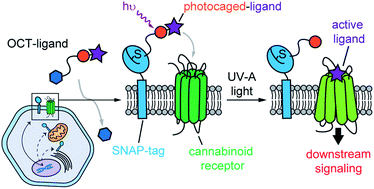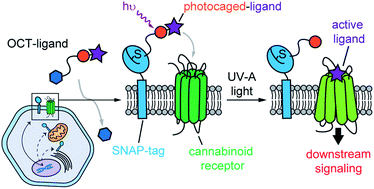

Image is from Tobias et. al, $Chem. Sci.$, 2021, 12, 13506–13512. 

OCTPEA covalently binds to mebrane SNAP-tags and does not allow for dye to bind to SNAP-tag. DMSO does not bind to SNAP-tags. Membrane SNAP-tags tethered to a dye (Alexa 488).

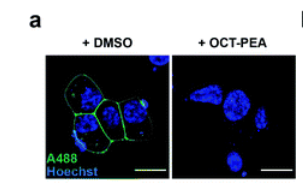

# Familiarzing ourselves with Ca <sup>2+ </sup> Imaging data 
For this notebook, we will only be using a small portion of the data published in Tobias et. al, $Chem. Sci.$, 2021, 12, 13506–13512.

Here, we have 3 different ligand conditions: Dimethyl sulfoxide (DMSO, vehicle control), OCTPEA, and CID 16020046 (CID, a selective GPR55 antagonist). 



Note that these Ca<sup>2+</sup> Imaging files are separated by condition and each condition has multiple trials. Each trial is a .csv file that has data collected from a live video. In our .cvs file, each row is a frame in the video (there are a total of 410 frames in these videos) and the columns of our .csv file represent a cell- each trial has a different number of cells. The numbers represent changes in fluorescence intensity of our Ca<sup>2+</sup> sensor in every cell at every frame. 
## Exercise 1 
Sometimes we might have all of our data in one file as we slowly collect it. As we have seen in the last 9 weeks, lets take a look at one of our DMSO (vehicle control) trials. 
* Using the pd.read_csv function, make it an array and save our DMSO1 trial to DMSO_trial1. 
* How many cells are in our DMSO trial 1? (hint: check its shape)

In [37]:
#Answer 
D= pd.read_csv('data/DMSO/DMSO1.csv', header=None,index_col=0)
DMSO_trial1=D.values
print("DMSO_trial1 has",DMSO_trial1.shape[1], "cells")

DMSO_trial1 has 66 cells


## Normalizing Our Data 
For all of our data sets we will normalize our data to the mean of first 5 frames to every cell. 

In [92]:
baseline=np.mean(DMSO_trial1[:5,:],axis=0,keepdims=True)

## Exercise 2 
Normalize DMSO_trial1 to the baseline and set this to  DMSO_trial1_norm.

In [93]:
#Answer 
DMSO_trial1_norm= DMSO_trial1/baseline 

## Measuring Changes in Oscillations  
In our analysis we want to investigate how photo releasing PEA affects [Ca<sup>2+</sup>] oscillations and one way to do this is by looking at changes in peaks of fluorescence intensity of our Ca<sup>2+</sup> sensor. 

Images below are from https://blog.ytotech.com/2015/11/01/findpeaks-in-python/ 

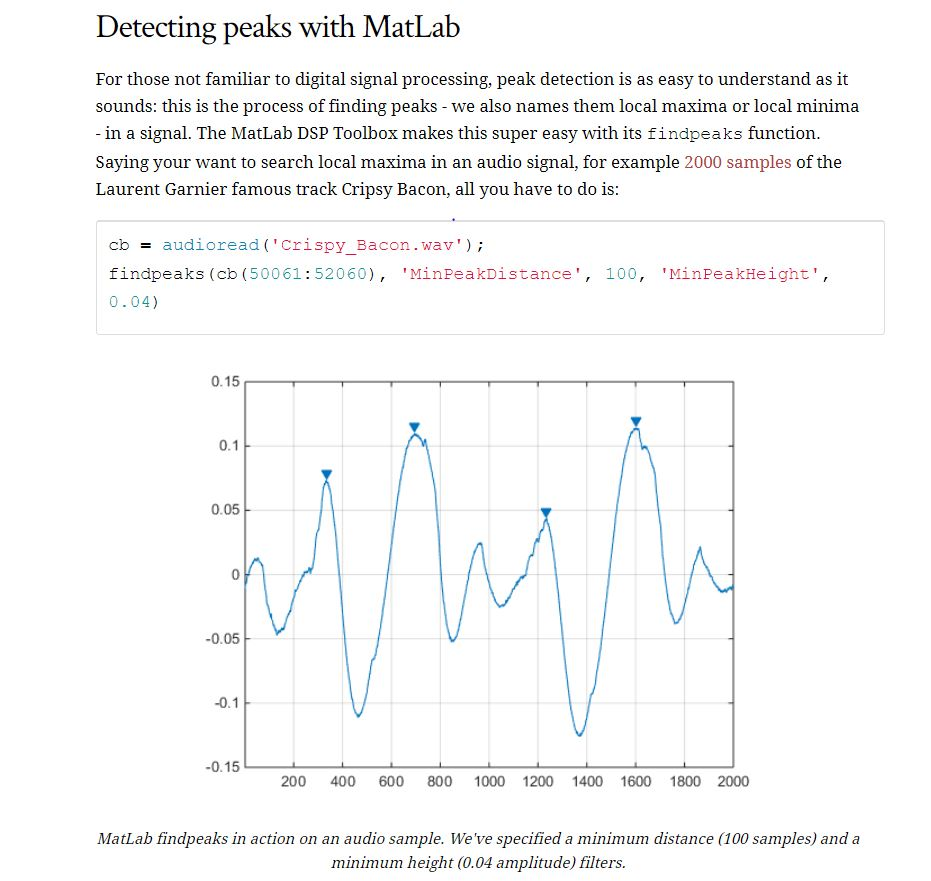

#### There is no findpeaks function in python, but Marcos Duarte wrote a package called "detecta" to help us detect peaks with python the way we would in  matlab (https://nbviewer.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb). 

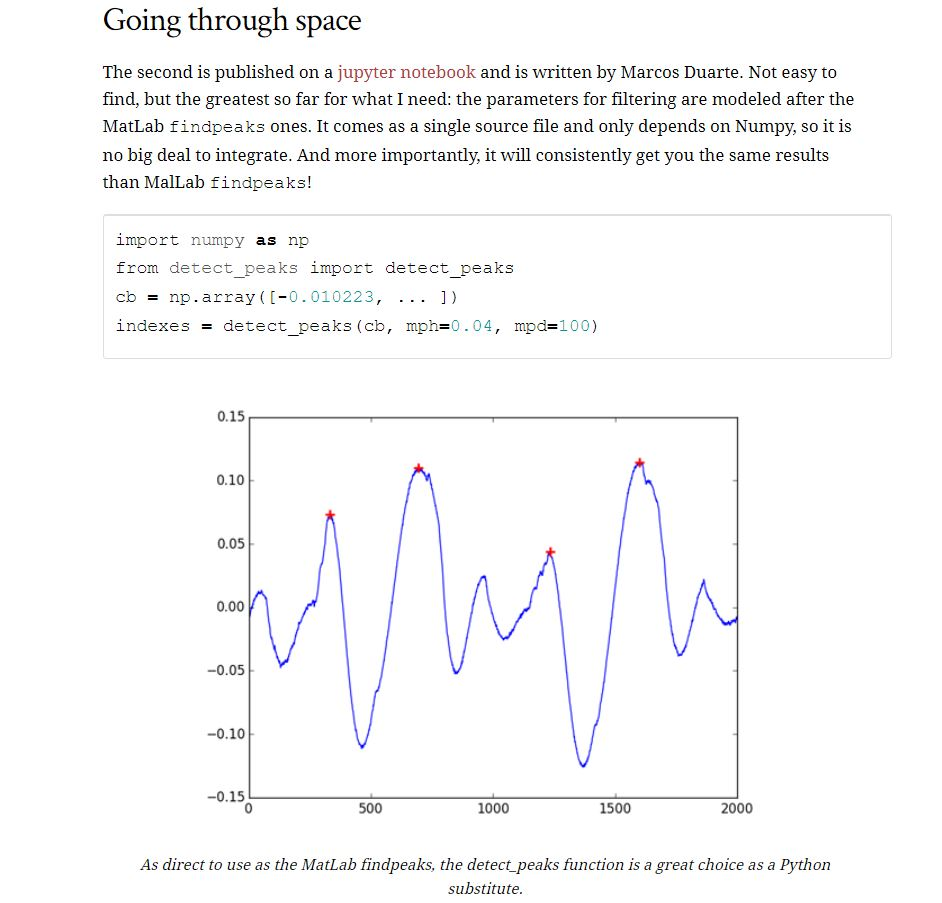

## Let's Find Some Peaks in Our Data 
In these live imaging videos to release PEA from its photocage, we use UV irradition (375 nm) at two different time points for 15 frames. 
Here I am finding the peaks before irradtion using detect_peaks for all cells in DMSO_trial1_norm. Because we have multiple cells in our array, we need a for loop to detect the peaks for each one. 
Some key arguments for detect peaks: 
* mph : essentially our peak height along the y axis. Our threshold here is 1.25, so peaks accounted for must  be 1.25 greater than the signal before and after 
* mpd: finds the tallest peak and elimnates peaks in x direction on either side of the peak. Here, our threshold is 2. 


In [102]:
UV1f= 150 #frame number where first irradiation occurred
ypeakthreshold= 1.25 
xpeakthreshold= 2
all_peaks=[] #empty list for all of our peaks 
all_cells_peaks = list() #will later store the number of peaks per cell 
for cell  in range(DMSO_trial1_norm.shape[1]):                   
    findprepeak= detect_peaks(DMSO_trial1_norm[:UV1f,cell], mph=ypeakthreshold, mpd=xpeakthreshold) #finding peaks of cells in all the frames before UV
    all_peaks.append(findprepeak)
    all_cells_peaks.append(len(findprepeak))
mean_peak_count = sum(all_cells_peaks) / DMSO_trial1_norm.shape[1] #want the mean number of peaks in this trial to later find our oscillation frequency
mean_peak_count

10.348484848484848

In [105]:
def peak_plot(cell,trial,peaks):
    fig, ax = plt.subplots()
    ax.plot(trial[:UV1f,cell]); 
    ax.scatter(peaks[cell], trial[:UV1f,cell][peaks[cell]], color="red" )
    peaks=trial[0:150,cell][all_peaks[cell]]
    return print(fig, ax, "The peaks for this cell are",peaks) 

Figure(432x288) AxesSubplot(0.125,0.125;0.775x0.755) The peaks for this cell are [2.89587122 3.06508523 2.96507166 2.93194066 3.18887958 3.26226424
 3.0614336  2.39695884]


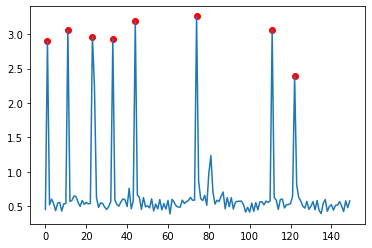

In [106]:
peak_plot(0,DMSO_trial1_norm, all_peaks) 

## Exercise 3 
Using peak_plot, look at the peaks of any cell in DMSO_trial1_norm. 

Figure(432x288) AxesSubplot(0.125,0.125;0.775x0.755) The peaks for this cell are [3.92307192 1.35515426 1.3443638  6.49669964 3.23967557 1.2783516
 1.36467525 1.60544966 1.51150923 7.59478717 1.31833976 1.39408368
 6.4452863  1.47808167 1.26227256 1.45099889 7.31550479 1.39281422
 1.40043101 1.28152527 1.3816023 ]


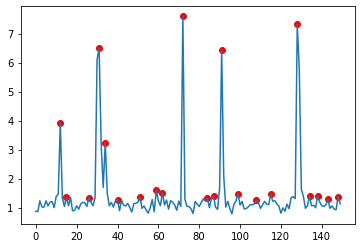

In [107]:
#answer
peak_plot(5,DMSO_trial1_norm, all_peaks) 

As you can see, every cell within this trial has a different number of peaks which is why we take the mean peak count for each trial. 

## Exercise 4 
For DMSO_trial1_norm, find the peaks in the frames between UV1f and UV2f and set these to "findpostpeak." Then, normalize the number of findpostpeak to the total number of cells in DMSO_trial1- set this to "postpeaksnorm." UV1f is 150 and UV2f is 300. 

In [110]:
#Answer 
UV1f= 150 #frame number where first irradiation occurred
UV2f= 300
ypeakthreshold= 1.25 #only count peak if it is 1.25 larger, peak must be at least this value greater in y than signal before / after, mph 
xpeakthreshold= 2 #finds tallest peak and eliminates peak in x direction on either side of peak mpd, 
all_postpeaks=[]
allpost_cells_peaks = list()
for cell  in range(DMSO_trial1_norm.shape[1]):                 
    findpostpeak= detect_peaks(DMSO_trial1_norm[UV1f:UV2f,cell], mph=ypeakthreshold, mpd=xpeakthreshold) #find peaks withindataset and generate an array
    all_postpeaks.append(findprepeak)
    allpost_cells_peaks.append(len(findpostpeak))
mean_post_peak_count = sum(allpost_cells_peaks) / DMSO_trial1_norm.shape[1]
mean_post_peak_count 

12.787878787878787

# Organizing Our Data to Find Fold Changes in Peaks 
We have 3 different Conditions: DMSO, GPR55 Inhibitor (CID for short), and OCTPEA. Let's say you cannot remember what conditions are in your data folder. Using pathlib's function pl.path, we can look at all the items in our data folder like so. 

In [111]:
datapath=pl.Path("data")
print (list(datapath.iterdir()))

[WindowsPath('data/DMSO'), WindowsPath('data/GPR55 Inhibitior'), WindowsPath('data/OCTPEA')]


Each output is a different folder. I separated all my paths for each condition in order to pull all the trials within each condition later.

In [112]:
DMSOpath = 'data/DMSO/' # use your path
DMSOfiles = glob.glob(DMSOpath + "/*.csv")
OCTPEApath= 'data/OCTPEA' 
OCTfiles= glob. glob(OCTPEApath +"/*.csv") 
CIDpath= 'data/GPR55 Inhibitior' 
CIDfiles=glob. glob(CIDpath +"/*.csv") 

To organize our different trials and conditions, we will store all of our trials in a list called "data_ins" and keep track of the trial conditions with the list "conditions."

In [116]:
data_ins= []
conditions = []
for filename in DMSOfiles:
        df = pd.read_csv(filename, index_col=0, header=None, delimiter=',')
        d = df.values #turning this df into an array 
        print("d.shape:",d.shape) #looking at the shape of all of my DMSO trials 
        dmean=np.mean(d[:5,:],axis=0,keepdims=True) #baseline of the first 5 frames for every trial
        print("dmean shape:", dmean.shape)
        d /= dmean #dividing every trial by its baseline 
        data_ins.append(d)
        conditions.append('DMSO')

d.shape: (410, 66)
dmean shape: (1, 66)
d.shape: (410, 59)
dmean shape: (1, 59)
d.shape: (410, 50)
dmean shape: (1, 50)
d.shape: (410, 72)
dmean shape: (1, 72)


Recall that every trial has the same number of frames in our video and different number of cells. 

In [117]:
for filename in OCTfiles:
    df = pd.read_csv(filename, index_col=0, header=None, delimiter=',')
    d = df.values
    dmean=np.mean(d[:5,:],axis=0,keepdims=True)
    d /= dmean
    data_ins.append(d)
    conditions.append('OCTPEA')

## Exercise 5
Now, add the CID files to the data_ins and conditions lists. 

In [118]:
#Answer
for filename in CIDfiles:
    df = pd.read_csv(filename, index_col=0, header=None, delimiter=',')
    d = df.values
    dmean=np.mean(d[:5,:],axis=0,keepdims=True)
    d /= dmean
    data_ins.append(d)
    conditions.append('CID')

Lets see what our cell counts are for each trial and how our trials are organized in our lists. 

In [119]:
cellcounts=[d.shape[1] for d in data_ins]
print(cellcounts)
print(conditions) 

[66, 59, 50, 72, 70, 28, 37, 64, 82, 24, 47, 46, 66, 30, 56, 60]
['DMSO', 'DMSO', 'DMSO', 'DMSO', 'OCTPEA', 'OCTPEA', 'OCTPEA', 'OCTPEA', 'OCTPEA', 'OCTPEA', 'OCTPEA', 'OCTPEA', 'CID', 'CID', 'CID', 'CID']


## Finding Peaks for Multiple Data Sets 
Now that we have all of our data arrays organized in a list, we can find peaks for all of trials within each condition in an organized way. 


We want a code that will do all this for each individual trial and will store all the mean peak counts corresponding to that trial since every cell in every single trial has a different number of peaks. I only want it to sum the peaks for each individual trial and divide by each trial's cell number. To work around this, I wrote a funtion to find the peaks before any UV irradition where I can input a slice of my data_ins corresponding to my trial of interest. 

In [121]:
def find_prepeaks(d): 
    UV1f= 150 
    all_cells_prepeaks=list()
    for cell  in range(d.shape[1]):                   
        findprepeak= detect_peaks(d[:UV1f,cell], mph=1.25, mpd=2)
        all_cells_prepeaks.append(len(findprepeak))
    mean_peak_count = sum(all_cells_prepeaks) / d.shape[1]
    return mean_peak_count

data_ins[0] is the equivalent of trial 1 in DMSO condition, which we have already found peaks for. 

In [123]:
#testing my function 
find_prepeaks(data_ins[0]) 

10.348484848484848

## Exercise 6
Write a function to find the peaks after the first irradiation, UV1f, and before the second irradiation, UV2f, and call the fuction find_postpeaks. 

In [50]:
#Answer 
def find_postpeaks(d): 
    UV1f= 150 
    UV2f= 300
    all_cells_prepeaks=list()
    for cell  in range(d.shape[1]):                   
        findprepeak= detect_peaks(d[UV1f:UV2f,cell], mph=1.25, mpd=2)
        all_cells_prepeaks.append(len(findprepeak))
    mean_peak_count = sum(all_cells_prepeaks) / d.shape[1]
    return mean_peak_count

To test both functions, we created I found the peaks before and after irradition for all of my DMSO trials. The mean peak counts for each trial will are stored in DMSO_prepeaks and DMSO_postpeaks. 

In [124]:
DMSO_prepeaks=[]
DMSO_postpeaks=[] 
for i in data_ins[:4]: 
    b=find_prepeaks(i) 
    DMSO_prepeaks.append(b) 
    c=find_postpeaks(i) 
    DMSO_postpeaks.append(c)
DMSO_prepeaks, DMSO_postpeaks 

([10.348484848484848, 12.64406779661017, 14.34, 12.694444444444445],
 [12.787878787878787, 14.11864406779661, 17.76, 14.958333333333334])

## Exercise 7
Now, using the two finding peaks functions, write a script that will store all of our peaks before and after irradiation for every single trial within each condition in two seperate lists: peaks_before_flash and peaks_after_flash. 

In [55]:
#Answer 
peaks_before_flash =[]
peaks_after_flash=[]
for i in data_ins: 
    b=find_prepeaks(i) 
    peaks_before_flash.append(b) 
    c=find_postpeaks(i) 
    peaks_after_flash.append(c)

# Fold Change 
The fold change in peaks after irradition and peaks before irradiation is indicative of changes in our oscillation frequency after we release PEA from its photocage to activate GPR55. 

Here, I am slicing out the DMSO trials within my lists peaks_before_flash and peaks_after_flash to calcualte the fold changes in all of these trials. 

In [56]:
DMSO_prepeaks=peaks_before_flash[:4]
DMSO_postpeaks=peaks_after_flash[:4]
DMSO_foldchanges=[]
for i in range(len(DMSO_prepeaks)): 
    foldchange=DMSO_postpeaks[i]/DMSO_prepeaks[i]
    DMSO_foldchanges.append(foldchange) 
DMSO_foldchanges 

[1.2357247437774523, 1.116621983914209, 1.2384937238493725, 1.1783369803063457]

To make this easier I wrote a function called fold changes that will do this for any of our conditions using proper slicing of our lists. 

In [125]:
def foldchanges(pre,post): 
    condition_foldchanges=[]
    for i in range(len(pre)): 
        foldchange=post[i]/pre[i] 
        condition_foldchanges.append(foldchange) 
    return condition_foldchanges

## Exercise 8
Slice out the OCT and CID peaks before and after irradiation. 

OCTPEA trials in our lists are [4:12] and store peaks before and irradiation in OCT_prepeaks and OCT_postpeaks, respectively. 

CID trials in our lists are [12:16] and store peaks before and irradiation in CID_prepeaks and CID_postpeaks, respectively. 

In [109]:
#Answer 
OCTPEA_prepeaks=peaks_before_flash[4:12]
OCTPEA_postpeaks=peaks_after_flash[4:12]
CID_prepeaks=peaks_before_flash[12:16]
CID_postpeaks=peaks_after_flash[12:16]

Using our fold changes function, we now have a list of fold changes for every condition. 

In [126]:
DMSO_foldchanges=foldchanges(DMSO_prepeaks,DMSO_postpeaks)
OCTPEA_foldchanges=foldchanges(OCTPEA_prepeaks, OCTPEA_postpeaks) 
CID_foldchanges=foldchanges(CID_prepeaks, CID_postpeaks) 

## Ploting our Oscillation Frequency for Statistical Analysis 

Before I use seaborn to plot my data into box plots, I created a dataframe, "folds", for all of my fold changes. 

In [127]:
allfolds={'DMSO' : DMSO_foldchanges,'OCTPEA' : OCTPEA_foldchanges,'CID' : CID_foldchanges}
folds=pd.DataFrame({ key:pd.Series(value) for key, value in allfolds.items() })
folds

,DMSO,OCTPEA,CID
0,1.235725,1.665428,1.160480
1,1.116622,1.703504,1.440433
2,1.238494,2.408784,0.997361
3,1.178337,1.374202,1.324378
4,NaN,1.536723,NaN
5,NaN,2.429688,NaN
6,NaN,1.801739,NaN
7,NaN,1.461538,NaN


When you want to decide on any statistal analysis, you should ALWAYS look at your data to see how it is distributed, to see if there is variability within conditions pulling your data one direction, to see how each condition looks in comparison, etc. This will help you decide on the best and most appropriate statistical test to perform. 

(<AxesSubplot:xlabel='Condition', ylabel='Oscillation Frequency (Fold Change)'>,
 <AxesSubplot:xlabel='Condition', ylabel='Oscillation Frequency (Fold Change)'>)

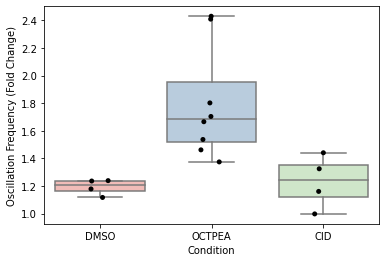

In [64]:
b=sns.boxplot(data=folds,palette='Pastel1') 
b.set(xlabel='Condition',ylabel='Oscillation Frequency (Fold Change)')
d=sns.stripplot(data=folds, color="Black") 
b,d

## Statistics On Our Fold Changes 

If we look at our boxplots, we can see that our data points are not necessicarily normally distrbuted and each condition has a different number of trials. We also have more than two conditions so a t-test would likely not work for this unless we want to focus on two of our groups. 

### Deciding on an Omnibus Test: 
### Statistical Test that determines if there is a significant difference between $all$ groups
Because we have more than two groups we need to decide on a statistical test that will first tell us if there is a significant difference between all of our groups. Typically, the first omnibus test that comes to mind is.. 
#### One-way Anaylsis of Variance (ANOVA) 
A one-way ANOVA looks at the variance between groups/ variance within groups. 

For equation enthusiats: 

$MST$: Mean square between treatments 
$MSE$: Mean square error within groups 


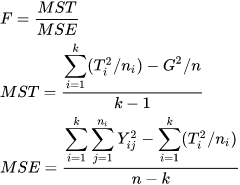


It also has 3 assumptions: 
   * Normally Distributed Data 
   * Equal Variances - variances of our data population between groups is similar 
   * Independence- each group is indepent from one another




Immediately when I look at this data, I want to perform a one-way ANOVA, but let's stop and think- does it meet all of the assumptions? 

#### Determining Equal Variance with Bartlett's Test
If you want to be a little more conservative with your analysis, to determine if there is equal variance between our groups, we can perform a Bartlett's test which has a null hypothesis that the variance among each group is similar and the alternative hypothesis that the variance among the groups is different. 

For those curious about the math of this test: https://www.statology.org/bartletts-test-in-r/

Luckily scipy.stats has this bartlett test that we imported at the beginning, so we do not do this by hand. 

In [131]:
stat, p = bartlett(DMSO_foldchanges, OCTPEA_foldchanges, CID_foldchanges)
print ("Our Bartlett p-value is", p) 

Our Bartlett p-value is 0.01479532022133389


##### Do our groups have equal variance? 

### Kruskal-Wallis Test 
No, our groups do not have equal variance so the alternative to perform a Kruskal-Wallis test, which in short is a non-parametric one-way ANOVA with ranks. If you are interested in the equation, (https://en.wikipedia.org/wiki/Kruskal%E2%80%93Wallis_one-way_analysis_of_variance). Instead of a mean like in a parametric one-way ANOVA, the Kruskal-Wallis test assess differences in median. 
The scipy.stats has a function called kruskal that will perform this test for us. If the output is statistically significant, we know that there is a statistically significant difference between our groups betweeen all our groups.

## Exercise 9 
Using the ss.kruskal function, determine if there is a statiscally significant difference between all of our condition fold changes. 

In [132]:
#Answer 
ss.kruskal(DMSO_foldchanges, OCTPEA_foldchanges, CID_foldchanges)

KruskalResult(statistic=10.648897058823536, pvalue=0.004871036507044393)

### Post Hoc Analysis- Group by Group Comparison 
### Dunn's Test 
If our omnious test is positive, we now need to see which gorups are different from which. A post-hoc analysis for the Kruskal-Wallis Test is the Dunn's test which is a pairwise comparison test between each of our independent groups and tells us which groups are significantly different from one another. 
### The Bonferroni Adjustment 
Additionally, when making multiple comparisons at once, we want to control for our false postive rate, thus we have to adjust our p-values. 
One way to do this is with the Bonferroni adjustment, which basically is 
##### p_adjusted= the original_pvalue $x$ the total number of comparisons made 

We can account for this adjustment in our scikit_posthocs (sp) Dunn test function: sp.posthoc_dunn with the argument p_adjust= 'bonferroni'

In [138]:
sp.posthoc_dunn([DMSO_foldchanges, OCTPEA_foldchanges, CID_foldchanges], p_adjust = 'bonferroni')

,1,2,3
1,1.000000,0.015967,1.000000
2,0.015967,1.000000,0.034257
3,1.000000,0.034257,1.000000


Our statistics shows that the OCTPEA fold changes are significanly greater than both the DMSO and CID conditions pointing to the idea that when we uncage PEA, it increases the Ca<sup>2+</sup> oscillation frequency in Ins-1  $\beta$-cells via downstream effects of GPR55 activation. 

## Plotting Our Ca<sup>2+</sup> Traces 
Here instead of having a list of arrays, we have mean of all of our cell traces within each trial for every condition. 

We want to normalize all of my data within each individual trial within each condition and find the mean trace overtime for each condition 

In [144]:
#recall our data paths 
DMSOpath = 'data/DMSO/' # use your path
DMSOfiles = glob.glob(DMSOpath + "/*.csv")
OCTPEApath= 'data/OCTPEA' 
OCTfiles= glob. glob(OCTPEApath +"/*.csv") 
CIDpath= 'data/GPR55 Inhibitior' 
CIDfiles=glob. glob(CIDpath +"/*.csv") 

### Function for Mean of all Trials 
Here I wrote a function calculate the mean of all trials within a condition. The output is an array of the mean flourescent trace of the condition. 

In [145]:
def meanofalltrials(filelist):
    consolidated_norm= list()
    for filename in filelist:
        df = pd.read_csv(filename, index_col=0, header=None, delimiter=',')
        baseline = np.mean(df.values[:5,:], axis=0)
        baseline.shape
        n=df.values/baseline 
        consolidated_norm.append(n)
    concat_cells=np.concatenate(consolidated_norm, axis=1)
    meanovertime=np.mean(concat_cells, axis=1) 
    return meanovertime

##### Organizing what different frames in our Ca<sup>2+</sup> videos mean: 

In [147]:
UV1f= 150 #frame number where first irradiation occurred
UV2f= 300 #frame number where second irradiation occurred 
UVdur= 15 #number of frames for each irradiation 
kcl= 400 #frame number where positive control was added 
frametime= 4 #experiment was conducted by imaging 4 sec per frame 

##### Converting from frames to seconds for important irradition time points: 

In [148]:
#convert units from frames to seconds 
UV1= UV1f*frametime-frametime 
UV2= UV2f*frametime-frametime
UVdur= UVdur*frametime
kcl_time=kcl*frametime-frametime

#### Plotting the Mean Ca<sup>2+</sup> Trace for Trials with OCT-PEA

In [163]:
octpea=meanofalltrials(OCTfiles)  

We need to set up our time axis by converting the total number of frames in each video (410) and multiplying it by the frametime (4 sec per frame). 

In [161]:
frametime=4 
times= np.arange(octpea.shape[0])*frametime #here I use the shape of axis 0 in our mean trace array

Note that when we plot this, our y-axis represents the change in fluorescence of our Ca<sup>2+</sup> sensor, RGECO, normalized to our mininum fluorescence  at baseline, F/F<sub>min</sub>. The overall plot shows us what this change in fluorescence  looks like over time. 

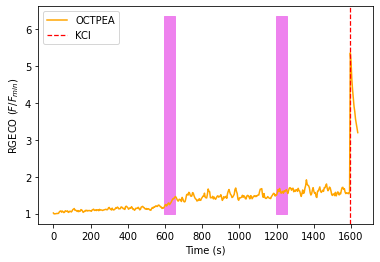

In [164]:
fig, ax = plt.subplots()
plt.plot(times, octpea, label="OCTPEA",color='orange')
ax.add_patch(Rectangle((UV1,min(octpea)),UVdur, max(octpea),color="violet"))
ax.add_patch(Rectangle((UV2,min(octpea)),UVdur, max(octpea),color="violet"))
plt.axvline(kcl_time, color ="red", linestyle='--', label="KCl", linewidth=1.25)
ax.set_xlabel("Time (s)") 
ax.set_ylabel("RGECO $(F/F_{min})$") 
plt.legend()

Adding out control DMSO mean trace to our plot.

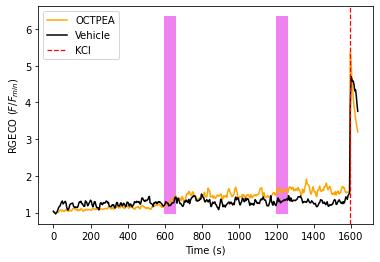

In [165]:
octpea=meanofalltrials(OCTfiles)  
ctrl=meanofalltrials(DMSOfiles) 
fig, ax = plt.subplots()
plt.plot(times, octpea, label="OCTPEA", color="orange")
ax.plot(times,ctrl, label="Vehicle", color="black")
ax.add_patch(Rectangle((UV1,min(octpea)),UVdur, max(octpea),color="violet"))
ax.add_patch(Rectangle((UV2,min(octpea)),UVdur, max(octpea),color="violet"))
plt.axvline(kcl_time, color ="red", linestyle='--', label="KCl", linewidth=1.25)
ax.set_xlabel("Time (s)") 
ax.set_ylabel("RGECO $(F/F_{min})$") 
plt.legend()

## Exercise 10
To our plot add the mean CID trace. Make sure to use the function meanofalltrials for our CIDfiles and set this to the variable cid. Make sure to label the plot properly so that we can distinguish the CID trace. 

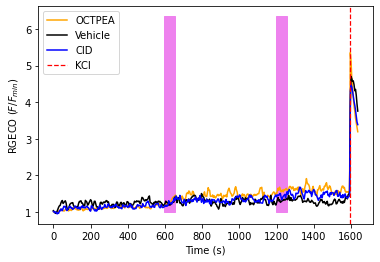

In [167]:
#Answer
cid=meanofalltrials(CIDfiles) 
octpea=meanofalltrials(OCTfiles)  
ctrl=meanofalltrials(DMSOfiles) 
fig, ax = plt.subplots()
plt.plot(times, octpea, label="OCTPEA", color="orange")
ax.plot(times,ctrl, label="Vehicle", color="black")
ax.plot(times,cid, label= 'CID', color="blue") 
ax.add_patch(Rectangle((UV1,min(octpea)),UVdur, max(octpea),color="violet"))
ax.add_patch(Rectangle((UV2,min(octpea)),UVdur, max(octpea),color="violet"))
plt.axvline(kcl_time, color ="red", linestyle='--', label="KCl", linewidth=1.25)
ax.set_xlabel("Time (s)") 
ax.set_ylabel("RGECO $(F/F_{min})$") 
plt.legend()